Train a GPR model with "RDkit featurization" and check performance by r2_score, MSE, MAE

In [2]:
# Train a GPR model with RDkit featurization
import deepchem as dc
import pandas as pd
import numpy as np

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [12]:
#load the dataset (polymer smiles and their energy of atomization)

print("loading the data...")
loader = dc.data.CSVLoader(["Eat"], feature_field="smiles", featurizer=dc.feat.RDKitDescriptors())
Data = loader.create_dataset('../csv_files/Polymers_Eat.csv')

loading the data...


In [4]:
#some RDKit descriptors return nan, make these 0
X = np.nan_to_num(Data.X, copy=True, nan=0.0, posinf=0)
#add data to dataset
Dataset = dc.data.DiskDataset.from_numpy(X=X, y=Data.y, w=Data.w, ids=Data.ids, tasks = ["Eat"])

In [5]:
X

array([[1.37878349, 0.        , 0.        , ..., 0.        , 0.        ,
        0.41472017],
       [1.37878349, 0.        , 0.        , ..., 0.        , 0.        ,
        0.40942379],
       [1.35164412, 0.        , 0.        , ..., 0.        , 0.        ,
        0.42790405],
       ...,
       [2.15586149, 0.        , 0.        , ..., 0.        , 0.        ,
        0.684136  ],
       [1.59625154, 0.        , 0.        , ..., 0.        , 0.        ,
        0.4229536 ],
       [3.36252535, 0.        , 0.        , ..., 5.        , 0.        ,
        0.17169943]])

In [19]:
#split the dataset using the random splitter
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(Dataset)
print("Data is splitted into: train, valid, test")

Data is splitted into: train, valid, test


In [20]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.ensemble import RandomForestRegressor
kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10))
#model = dc.models.SklearnModel(RandomForestRegressor(n_estimators=500))
print("fitting model...")
model.fit(train_dataset)
print("model is fitted")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...
model is fitted


In [21]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 0.9999999999999996}
Test set score: {'pearson_r2_score': 0.9643507941650248}


In [22]:
#calculate RMSE score
from sklearn.metrics import root_mean_squared_error
RMSE_score = root_mean_squared_error(test_dataset.y,predicted)
print('tets set score:',RMSE_score)

tets set score: 0.05932920986125893


In [23]:
#convert tekst to string, so it can be depicted in matplotlib
r2=list(test_score.values())[0]
text = "r2= "+ str(round(r2,4)) + " & RMSE= " +str(round(RMSE_score,4))

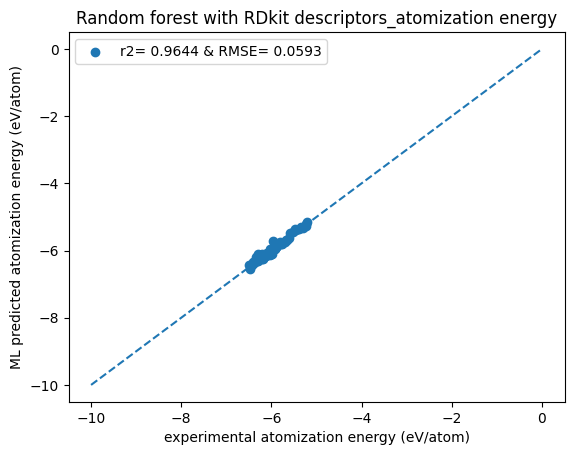

In [24]:
#plot the data
import matplotlib.pyplot as plt

x=[-10,0]
y=[-10,0]
#text = "R2= "+ str(round(test_score))
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label=text)
plt.legend()
plt.xlabel("experimental atomization energy (eV/atom)")
plt.ylabel("ML predicted atomization energy (eV/atom)")
plt.title("Random forest with RDkit descriptors_atomization energy")
plt.show()
